# Experiment n.2:

In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention
from tensorflow.keras import Model

In [2]:
nPastHours = 24
nPastHours2 = 48
nLabels = 1
nFuture = 1
batchSize = 16
epochs = 30
epochs2 = 100
patience = 2

In [3]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

In [4]:
plt.rcParams["figure.figsize"] = (12,8)

## Importing datasets

In [5]:
# real data
real_data = pd.read_csv('real_data.csv')
real_data = real_data[['PM10 Concentration', 'PM2.5 Concentration']]

# trend
trend = pd.read_csv('trend_cleaned.csv')
trend = trend[['PM10 Concentration', 'PM2.5 Concentration']]

# trend + seasonal
trend_seasonal = pd.read_csv('trend_seasonal_cleaned.csv')

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

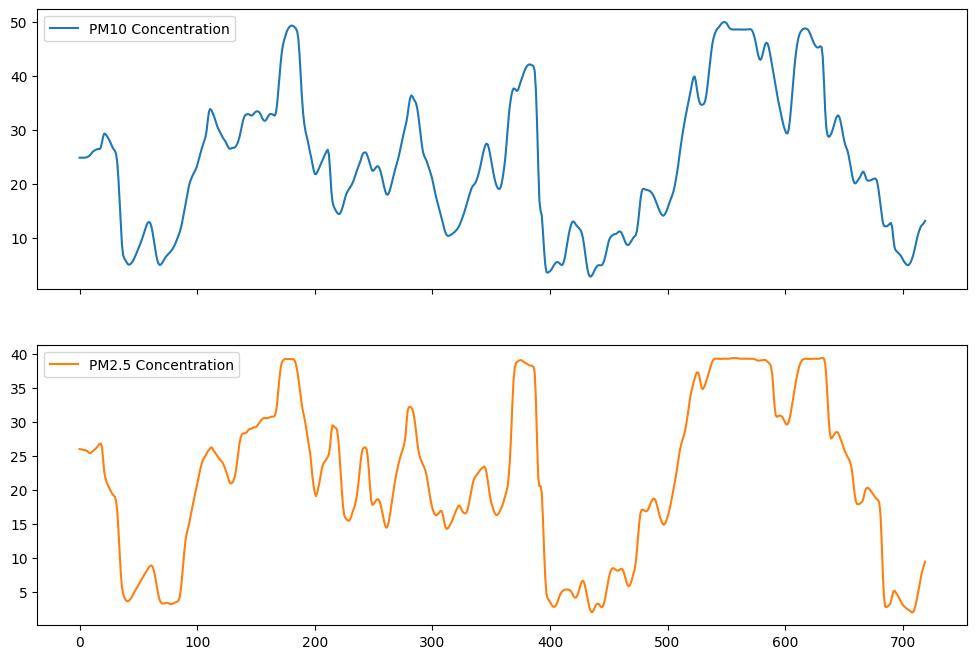

In [6]:
trend[:720].plot(subplots=True)

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

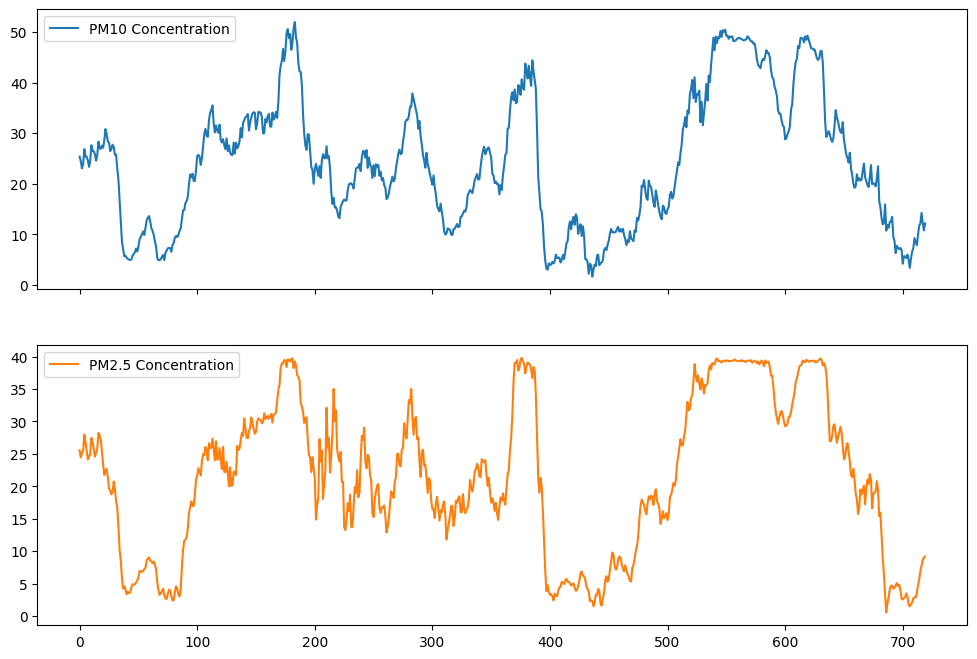

In [7]:
trend_seasonal[:720].plot(subplots=True)

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

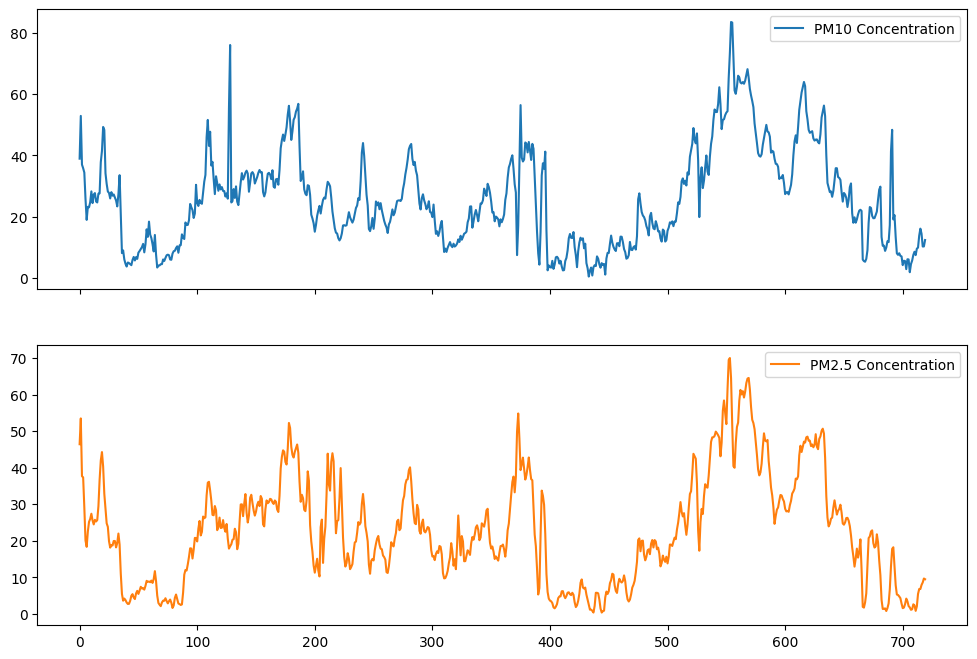

In [8]:
real_data[:720].plot(subplots=True)

### Data scaling

In [9]:
trend_scaler = MinMaxScaler()
trend_seasonal_scaler = MinMaxScaler()

trend = trend_scaler.fit_transform(trend)
trend_seasonal = trend_seasonal_scaler.fit_transform(trend_seasonal)

### Data windowing

In [10]:
trainData = trend[0:int(len(trend)*0.8), :]
testData = trend[int(len(trend)*.8):, :]

trainX = []
trainY = []

for i in range(nPastHours, len(trainData) - nFuture + 1):
    trainX.append(trainData[i - nPastHours: i, 0: trainData.shape[1]])
    trainY.append(trainData[i + nFuture - 1: i + nFuture, :]) # PM10 je zvoleny ako y label

trainX = np.array(trainX)
trainY = np.array(trainY)
trainY = trainY.squeeze()
print(f'trainX shape: {trainX.shape}; trainY shape: {trainY.shape}')

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, 0: testData.shape[1]])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

trainX shape: (21020, 24, 2); trainY shape: (21020, 2)
testX shape: (5237, 24, 2)


## Model n.1

In [11]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [12]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(units=2)(x)
    return tf.keras.Model(inputs, outputs)

In [13]:
model1 = build_model(trainX.shape[1:], head_size=128, num_heads=4, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.3, dropout=0.2)
model1.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[
            tf.keras.metrics.MeanAbsoluteError(),
            tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsolutePercentageError()
        ]
    )
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 2)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 24, 2)       4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 24, 2)       5634        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [14]:
history = model1.fit(trainX, trainY, epochs=epochs, batch_size=batchSize, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/30
1183/1183 [==============================] - 31s 24ms/step - loss: 0.0491 - mean_absolute_error: 0.1691 - root_mean_squared_error: 0.2215 - mean_absolute_percentage_error: 73.4536 - val_loss: 0.0185 - val_mean_absolute_error: 0.1078 - val_root_mean_squared_error: 0.1361 - val_mean_absolute_percentage_error: 140086.6406
Epoch 2/30
1183/1183 [==============================] - 30s 25ms/step - loss: 0.0332 - mean_absolute_error: 0.1430 - root_mean_squared_error: 0.1822 - mean_absolute_percentage_error: 63.7862 - val_loss: 0.0181 - val_mean_absolute_error: 0.1025 - val_root_mean_squared_error: 0.1347 - val_mean_absolute_percentage_error: 100463.0000
Epoch 3/30
1183/1183 [==============================] - 29s 25ms/step - loss: 0.0309 - mean_absolute_error: 0.1370 - root_mean_squared_error: 0.1758 - mean_absolute_percentage_error: 60.9505 - val_loss: 0.0267 - val_mean_absolute_error: 0.1255 - val_root_mean_squared_error: 0.1635 - val_mean_absolute_percentage_error: 105777.3516
Epoc

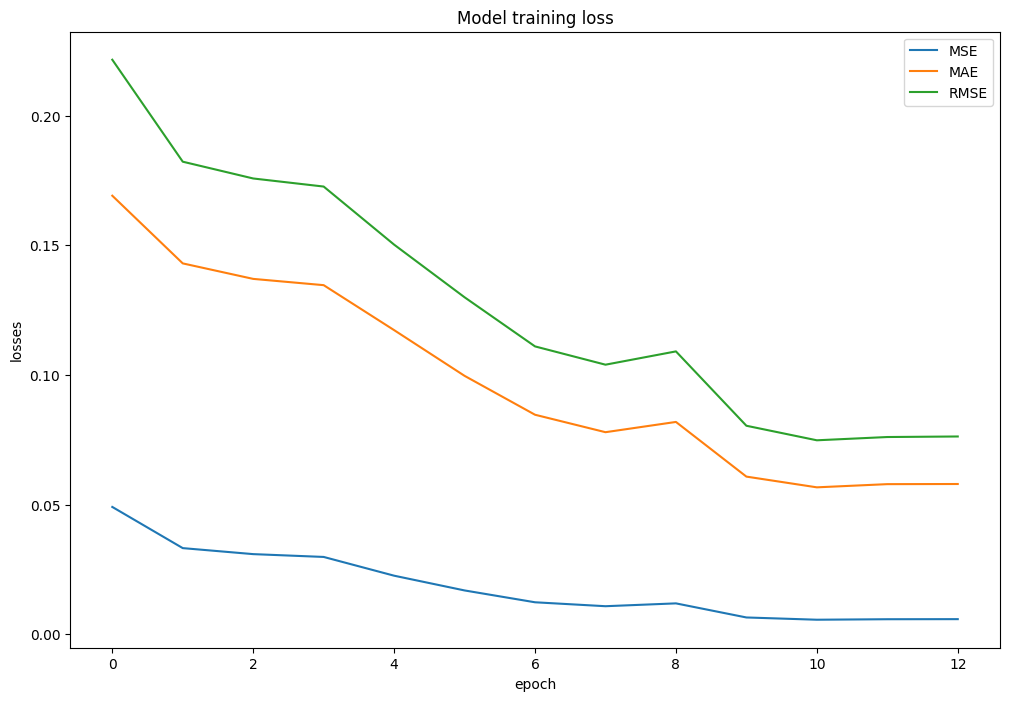

In [15]:
plt.plot(history.history['loss'], label='MSE')
plt.plot(history.history['mean_absolute_error'], label='MAE')
plt.plot(history.history['root_mean_squared_error'], label='RMSE')
plt.title('Model training loss')
plt.ylabel('losses')
plt.xlabel('epoch')
plt.legend()
plt.show()

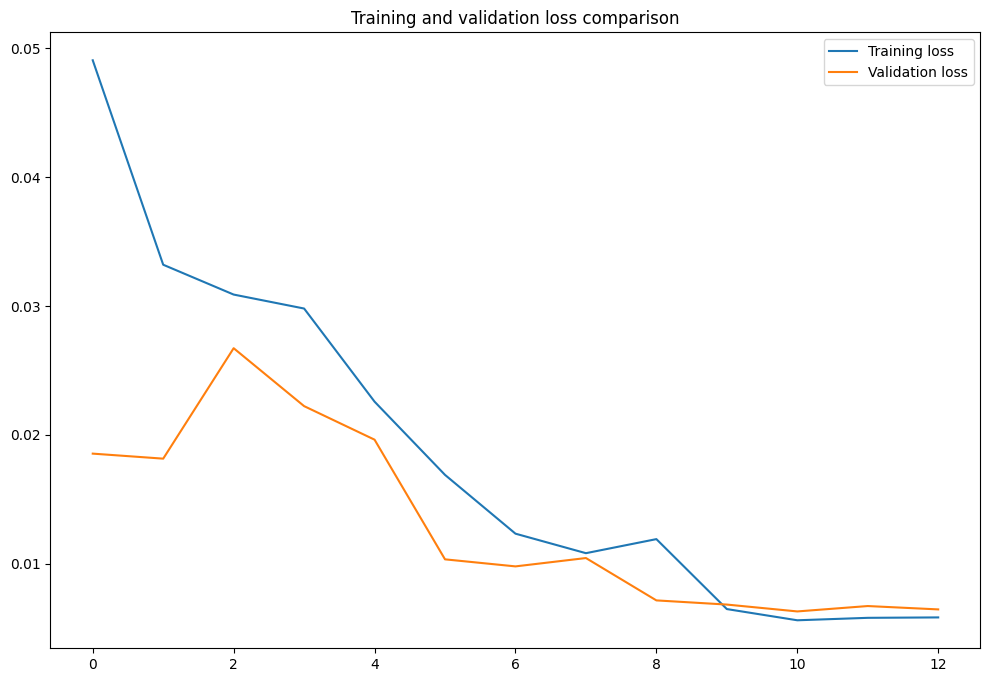

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss comparison')
plt.legend()

### Model evaluation

In [17]:
def plotAndEvaluate(model, scaler, timeseries, realData, testData, past_hours=200):
    realData = realData[-past_hours:]
    testData = testData[-past_hours:]
    y_pred = model.predict(testX[-past_hours:])
    inv = pd.DataFrame({
        'pm10': y_pred[:, 0],
        'pm2.5': y_pred[:, 1],
    })
    inv = scaler.inverse_transform(inv)

    var1_perc25 = np.percentile(inv[:, 0], 25)
    var2_perc25 = np.percentile(inv[:, 1], 25)

    peaks1, _ = find_peaks(realData[:, 0], width=1)
    peaks2, _ = find_peaks(realData[:, 1], width=1)

    diffs1, diffs2 = [], []
    for x in peaks1:
        if realData[x][0] >= inv[x][0] + var1_perc25:
            diffs1.append(x)
    for x in peaks2:
        if realData[x][1] >= inv[x][1] + var2_perc25:
            diffs2.append(x)

    plt.plot(testData[:, 0], color='#fac516')
    plt.plot(realData[:, 0], color='#0496b0')
    plt.plot(inv[:, 0], color='#fa1616')
    for diff in diffs1:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM10 predictions')
    plt.show()

    plt.plot(testData[:, 1], color='#fac516')
    plt.plot(realData[:, 1], color='#0496b0')
    plt.plot(inv[:, 1], color='#fa1616')
    for diff in diffs2:
        plt.axvspan(diff-3, diff+3, facecolor='red', alpha=0.2)
    plt.legend(['Test data', 'Real data', 'Predictions'])
    plt.title('PM2.5 predictions')
    plt.show()

    metrics = dict()
    metrics['MAPE'] = mean_absolute_percentage_error(inv, realData)
    metrics['RMSE'] = math.sqrt(mean_squared_error(inv, realData))
    metrics['MAE'] = mean_absolute_error(inv, realData)
    return metrics

In [18]:
real_data = real_data[int(len(real_data)*0.8):]
real_data = real_data.to_numpy()

In [19]:
model1_metrics = dict()

### In: Trend (cleaned, normed)

In [20]:
test_data = trend[-200:]
test_data = pd.DataFrame(test_data)
test_data = trend_scaler.inverse_transform(test_data)

7/7 [==============================] - 0s 20ms/step


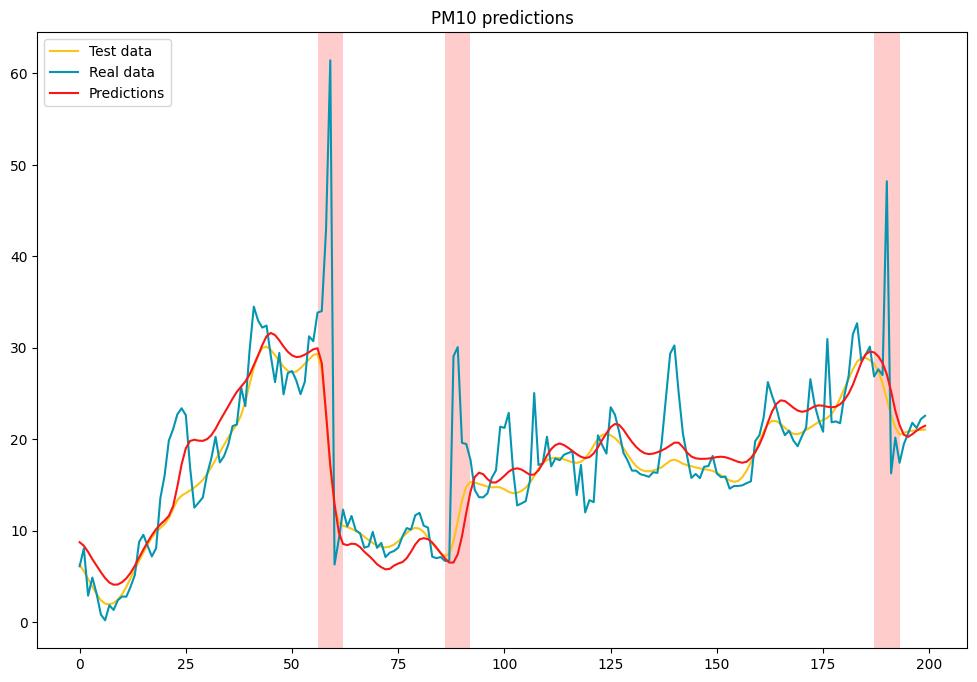

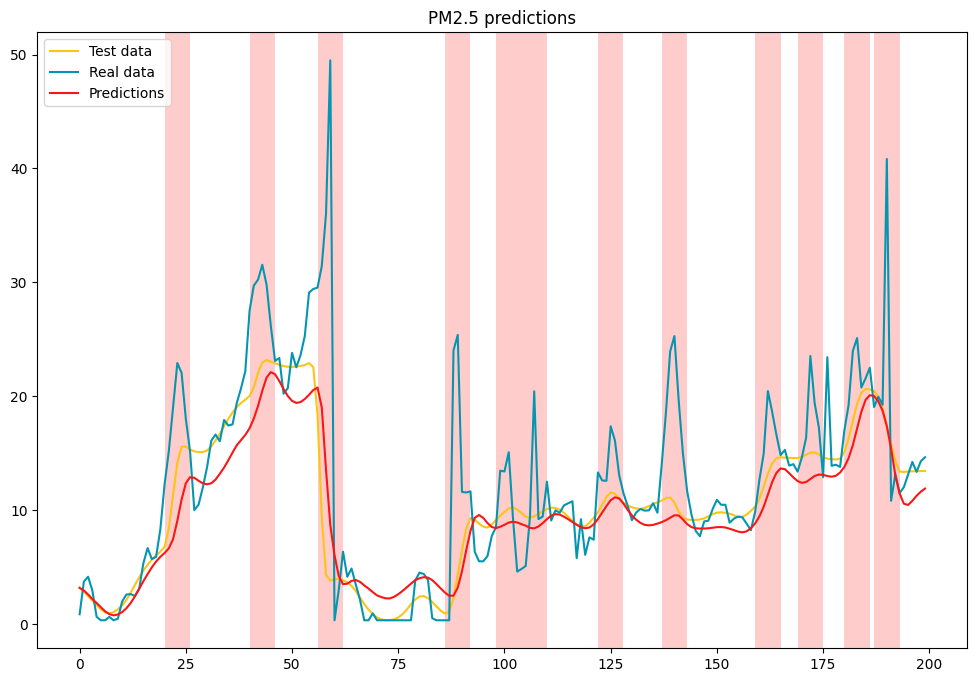

{'trend': {'MAPE': 0.3667880402988492,
  'RMSE': 5.8897655303577245,
  'MAE': 3.5480376737939396}}

In [21]:
model1_metrics['trend'] = plotAndEvaluate(model1, trend_scaler, testX, real_data, test_data)
model1_metrics

### In: Trend + Seasonal (cleaned, normed)

In [22]:
testData = trend_seasonal[int(len(trend_seasonal)*0.8):]

testX = []
for i in range(nPastHours, len(testData)):
    testX.append(testData[i-nPastHours: i, :])

testX = np.array(testX)
print(f'testX shape: {testX.shape}')

testX shape: (5237, 24, 2)


In [23]:
testData = pd.DataFrame(testData)
testData = trend_seasonal_scaler.inverse_transform(testData)

7/7 [==============================] - 0s 20ms/step


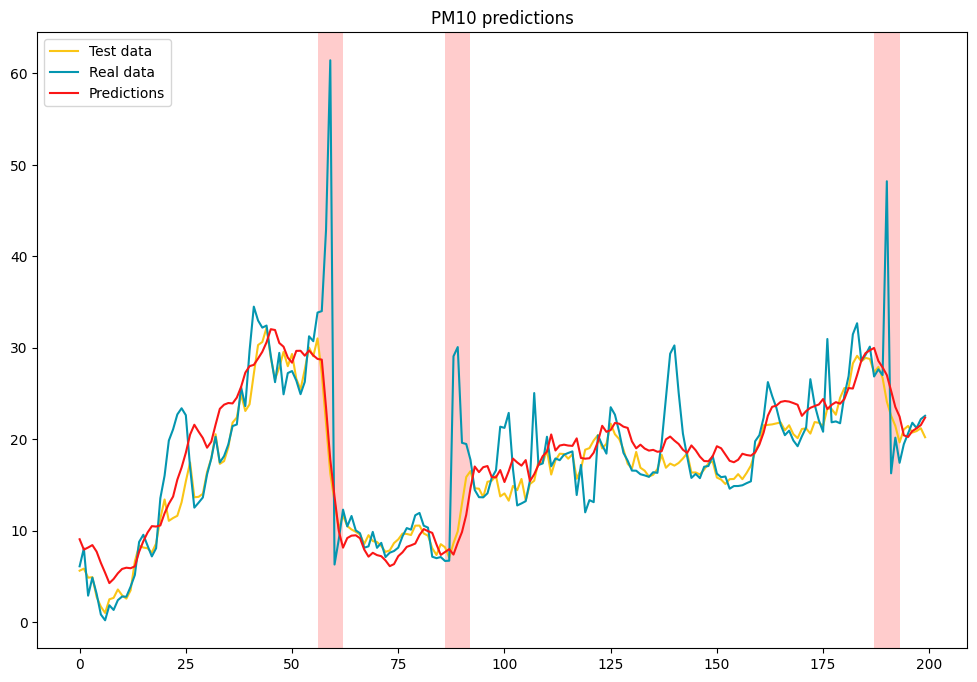

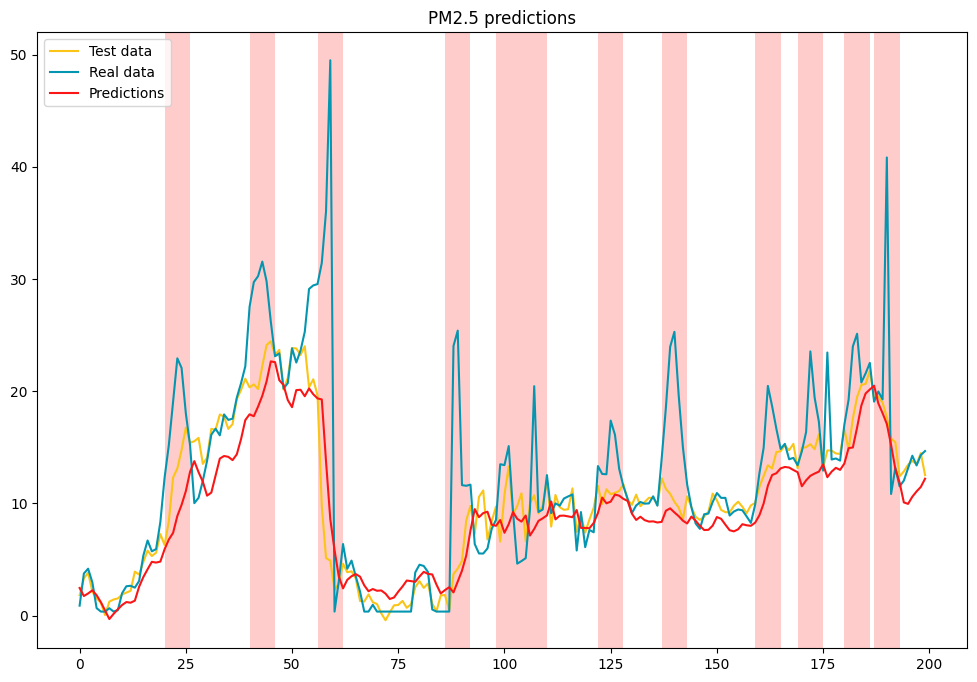

{'trend': {'MAPE': 0.3667880402988492,
  'RMSE': 5.8897655303577245,
  'MAE': 3.5480376737939396},
 'trend+seasonal': {'MAPE': 0.4039699718211442,
  'RMSE': 5.979150176364799,
  'MAE': 3.692896601073632}}

In [24]:
model1_metrics['trend+seasonal'] = plotAndEvaluate(model1, trend_seasonal_scaler, testX, real_data, testData)
model1_metrics